In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
from __future__ import print_function
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from torch import nn
from tqdm.auto import tqdm#show loop progress
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.models as models


import argparse
import os

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
import matplotlib.animation as animation
from IPython.display import HTML

from scipy import linalg
from torch.nn.functional import adaptive_avg_pool2d

from PIL import Image

import matplotlib.pyplot as plt
import sys
import numpy as np
import os
# print(os.listdir("../input"))

import time
from torchvision.models.inception import inception_v3
import numpy as np
from scipy.stats import entropy
from torch.autograd import Variable
from torch.nn import functional as F
import torch.utils.data
import torch
from torch import nn

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mnist-splitter/stdash_dataloader
/kaggle/input/mnist-splitter/svdash_dataloader
/kaggle/input/cnn-c1/cnn_c1(2).pt
/kaggle/input/fashion-mnist-splitter/fashion_test_loader
/kaggle/input/fashion-mnist-splitter/__results__.html
/kaggle/input/fashion-mnist-splitter/fashion_train_loader
/kaggle/input/fashion-mnist-splitter/__notebook__.ipynb
/kaggle/input/fashion-mnist-splitter/__output__.json
/kaggle/input/fashion-mnist-splitter/custom.css
/kaggle/input/fashion-mnist-splitter/data/FashionMNIST/processed/training.pt
/kaggle/input/fashion-mnist-splitter/data/FashionMNIST/processed/test.pt
/kaggle/input/fashion-mnist-splitter/data/FashionMNIST/raw/t10k-labels-idx1-ubyte
/kaggle/input/fashion-mnist-splitter/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz
/kaggle/input/fashion-mnist-splitter/data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
/kaggle/input/fashion-mnist-splitter/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz
/kaggle/input/fashion-mnist-splitter/data/FashionMNIST/raw

In [2]:
from six.moves import urllib    
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [3]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
cnn_c1 = torch.load('../input/cnn-c1/cnn_c1(2).pt')
cnn_c1.to('cuda')
cnn_c1.eval()

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): Tanh()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)

In [4]:
def find_data(trainloader,epoch):
    correct_count, all_count = 0, 0
    predicted_labels = []
    data = []
    for images in trainloader:
      for i in range(len(images)):
        #print(images[i].size())
        img = images[i].view(1, 784)

        with torch.no_grad():
            logps = cnn_c1(img)

        ps = torch.exp(logps)
        probab = list(ps.cpu().numpy()[0])
        pred_label = probab.index(max(probab))
        predicted_labels.append(pred_label)
        data.append([images[i],pred_label])
    len(data)
    gan_testloader = torch.utils.data.DataLoader(data, batch_size=64, shuffle=True)
    torch.save(gan_testloader, './gan_data_epoch_{}'.format(epoch))


In [5]:
train_loader = torch.load('../input/fashion-mnist-splitter/fashion_train_loader')
#test_loader = torch.load('../input/mnist-splitter/svdash_dataloader')

In [6]:
len(train_loader)

938

In [7]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
    
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])
model=model.cuda()


def calculate_activation_statistics(images,model,batch_size=128, dims=2048,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

def calculate_fretchet(images_real,images_fake,model):
     mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=True)
     mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=True)
    
     """get fretched distance"""
     fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
     return fid_value
    

from torchvision.models.inception import inception_v3
import numpy as np
from scipy.stats import entropy
from torch.autograd import Variable
from torch.nn import functional as F
import torch.utils.data
import torch
from torch import nn

def inception_score(imgs, cuda=True, batch_size=1, resize=False, splits=1):
    """Computes the inception score of the generated images imgs
    imgs -- Torch dataset of (3xHxW) numpy images normalized in the range [-1, 1]
    cuda -- whether or not to run on GPU
    batch_size -- batch size for feeding into Inception v3
    splits -- number of splits
    """
    N = len(imgs)

    assert batch_size > 0
    assert N > batch_size

    # Set up dtype
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        if torch.cuda.is_available():
            print("WARNING: You have a CUDA device, so you should probably set cuda=True")
        dtype = torch.FloatTensor

    # Set up dataloader
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)
    
    # Load inception model
    inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
    inception_model.eval();
    up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)
    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        return F.softmax(x).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batch = batch.type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

def PSNR(original, compressed): 
    mse = torch.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse)) 
    return psnr 
"""Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
"""
def MMD(x, y, kernel):
    print(x.size())
    print(y.size())
    x = x.view(x.size(0), x.size(2) * x.size(3))
    y = y.view(y.size(0), y.size(2) * y.size(3))
    print(x.size())
    print(y.size())

    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    
    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)
    
    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))
    
    if kernel == "multiscale":
        
        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1
            
    if kernel == "rbf":
      
        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)
      
      

    return torch.mean(XX + YY - 2. * XY)


Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [8]:
import torch
import numpy as np
import torchvision

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset, Dataset
rescale = lambda x: 2 * x -1

class MNISTDS(Dataset):
    def __init__(self, mnist_ds, transform):
        super().__init__()
        self.mnist_ds= mnist_ds
        self.transform = transform
    def __len__(self):
        return len(self.mnist_ds)
    def __getitem__(self, i):
        return self.transform(self.mnist_ds[i][0]), self.mnist_ds[i][1]

#ds = MNISTDS(mnist_ds, transform)

class Generator(nn.Module):
    def __init__(self, latent_size):
        """latent_size = size of the latent space"""
        super(Generator, self).__init__()

        self.latent_size = latent_size

        #kernel size
        self.kernel_size =4
        #(proportional to the) number of generator filters
        self.ngf = 64

        #takes a latent vector and outputs MNIST-sized image
        #input: (_, nz, 1, 1) latent vector
        self.upsample = nn.Sequential(

                                nn.ConvTranspose2d(self.latent_size, 4 * self.ngf, self.kernel_size,
                                                      stride=1,padding=0,bias=False),
                                nn.BatchNorm2d( 4 * self.ngf),
                                nn.ReLU(),
                                #spatial extent here is set by the kernel: (4,4)

                                #by setting stride=2, we effectively double the output size (up to fiddling
                                #with the boundary conditions..)
                                # Weirdly, increasing the 'padding' arg actually decreases the amount of padding
                                #that's applied to the input. the only reason padding is being used here is to
                                #keep the output shapes at nice multiples of two
                                nn.ConvTranspose2d(4 * self.ngf, 2 * self.ngf, self.kernel_size,
                                                      stride=2,padding=1, bias=False),
                                nn.BatchNorm2d( 2 * self.ngf),
                                nn.ReLU(),

                                #( 8,8)
                                nn.ConvTranspose2d(2 * self.ngf, 1 * self.ngf, self.kernel_size,
                                                      stride=2,padding=1, bias=False),
                                nn.BatchNorm2d( 1 * self.ngf),
                                nn.ReLU(),
                                #(16,16)
                                #here I'm increasing the padding to bring the output size to (28,28)
                                #for MNIST
                                nn.ConvTranspose2d(self.ngf, 1, self.kernel_size,
                                                      stride=2,padding=3, bias=False),
                                nn.Tanh(),
                                #(32,32)


                                )

    def forward(self, z):
        """Input: (_, latent_size) noise tensor
            Output: (_, 1, 32, 32) generated image tensor"""
        z = z.view(-1, self.latent_size, 1, 1)
        return self.upsample(z)
    
    

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        #scaling for the number of filters
        self.nf = 64
        # kernel size
        self.kernel_size = 4
        #input (1,28,28)

        #this is more or less the generator stack run in reverse
        # a stride of 2 and padding of 1 causes the spatial extent to halve at each step
        self.main = nn.Sequential(
            nn.Conv2d(1, self.nf, self.kernel_size, stride=2,padding=3, bias=False),
            nn.LeakyReLU(.2),
            nn.Conv2d(self.nf, 2 * self.nf, self.kernel_size, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(2 * self.nf),
            nn.LeakyReLU(.2),
            nn.Conv2d(2*self.nf, 4 * self.nf, self.kernel_size, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(4 * self.nf),
            nn.LeakyReLU(.2),
            nn.Conv2d(4*self.nf, 1 , self.kernel_size, stride=1, padding=0, bias=False),
            nn.Sigmoid()

        )

    def forward(self, x):
        """Input: (_, 1, 28, 28) image
            Output: (_, 1) classification tensor"""
        x = x.view(-1, 1, 28,28)
        return self.main(x).view(-1)

devname = "cuda:0" if torch.cuda.is_available() else "cpu"

device = torch.device(devname)

latent_size = 100

def weight_init(module):
    classname = module.__class__.__name__
    if classname.find('Conv')!=-1:
        module.weight.data.normal_(0.0, .02)
    elif classname.find('BatchNorm') != -1:
        module.weight.data.normal_(1.0, .01)
        module.bias.data.fill_(0.0)



G = Generator(latent_size).to(device)
D = Discriminator().to(device)

G.apply(weight_init)
D.apply(weight_init)

batch_size = 64

dl = train_loader#DataLoader(ds, batch_size=batch_size, shuffle=True)

loss = nn.BCELoss()

real_label = 1
fake_label = 1- real_label

lr = 2e-4
beta=.5

#One optimizer for each network. Makes it easy to update the two different sets of weights in alternating steps.

optimizerD = torch.optim.Adam(D.parameters(), lr=lr,betas=(beta, .999))
optimizerG = torch.optim.Adam(G.parameters(), lr=lr,betas=(beta, .999))

#How many passes to take over the dataset.

epochs = 201

disc_losses = []
gen_losses = []

savestep=0
generated_images = []
psnr_score = []
mmd_score = []
fid_score = []
is_score= []
checkpoint = [1,10,20,30,40,50,100,150,200]
for epoch in range(epochs):
    fake_image_array = []
    real_array = []
    print("Starting epoch %d..." % epoch)
    for i, (x,y) in enumerate(dl):
        x = x.to(device)
        y = y.to(device)

        #size of current batch
        N = x.shape[0]
        ## update the discriminator
        disc_real = D(x)
        real_probs = torch.full((N,), real_label, device=device).type('torch.FloatTensor').cuda()
        #print(real_probs.type())
        disc_loss_real = loss(disc_real, real_probs)

        z = torch.randn(N, latent_size,1,1,device=device)
        #detach here, so gradients don't flow to the generator
        fake_outputs = G(z).detach()
        
        if epoch in checkpoint:
            generated_images.append(fake_outputs)
            fake_image_array.append(fake_outputs)
            real_array.append(x)
        
        disc_fake = D(fake_outputs)
        fake_probs = torch.full((N,), fake_label, device=device).type('torch.FloatTensor').cuda()
        disc_loss_fake = loss(disc_fake, fake_probs)

        D.zero_grad()
        disc_loss = disc_loss_real+ disc_loss_fake
        disc_loss.backward()
        #update disc weights only
        optimizerD.step()

        ## update the generator
        z = torch.randn(N, latent_size, 1, 1, device=device)
        disc_fake = D(G(z))
        fake_labels = torch.full((N,), real_label, device=device).type('torch.FloatTensor').cuda()
        gen_loss = loss(disc_fake, fake_labels)

        G.zero_grad()
        gen_loss.backward()
        optimizerG.step()   

        if i % 25 ==0:
            print("generator_loss:%f,disc_loss:%f",(gen_loss.item(),disc_loss.item()))
            disc_losses.append(disc_loss.item())
            gen_losses.append(gen_loss.item())
    
    if epoch in checkpoint:
        print("========E=======P========O========C=========H=======:",epoch)
        if epoch in checkpoint:
#             temp = []
#             for batch in fake_image_array:
#                 for l in batch:
#                     temp.apped(l)
#             torch.utils.data.DataLoader(temp,shuffle=True)
            #fake_image = decoded_imgs
            #real = real_imgs
            fake_image = fake_image_array[0]
            real = real_array[0]
            psnr = []
            for i in range(len(fake_image)):
                psnr.append(PSNR(real[i],fake_image[i]))
            psnr = torch.FloatTensor(psnr)
            #PSNR_Score.append(torch.mean(psnr))              
            
            result = MMD(fake_image, real, kernel="multiscale")
            #print(f"MMD result of X and Y is {}")
        
            fretchet_dist=calculate_fretchet(real.repeat(1,3,1,1),fake_image.repeat(1,3,1,1),model)

            #print(fake.size())
            
            incp_mean,incp_std = inception_score(fake_image.repeat(1,3,1,1), cuda=True, batch_size=16, resize=True, splits=10)
            print(
            "[PSNR %f] [MMD %f] [FID: %f] [IS: %f]"
            % (torch.mean(psnr), result.item(), fretchet_dist,incp_mean)
            )
        temp_image = []
        for curr in generated_images:
            for i in curr:
                temp_image.append(i)
        trainloader = torch.utils.data.DataLoader(temp_image, batch_size=64, shuffle=True)
        find_data(trainloader,epoch)
        generated_images = []





Starting epoch 0...
generator_loss:%f,disc_loss:%f (1.055403232574463, 1.8074963092803955)
generator_loss:%f,disc_loss:%f (2.394918441772461, 0.43033283948898315)
generator_loss:%f,disc_loss:%f (5.902629852294922, 0.7026736736297607)
generator_loss:%f,disc_loss:%f (2.839948892593384, 0.2819865942001343)
generator_loss:%f,disc_loss:%f (3.4665679931640625, 0.23943591117858887)
generator_loss:%f,disc_loss:%f (5.505730628967285, 0.4871874451637268)
generator_loss:%f,disc_loss:%f (3.893880844116211, 0.20936375856399536)
generator_loss:%f,disc_loss:%f (5.259589195251465, 0.46397891640663147)
generator_loss:%f,disc_loss:%f (4.846120834350586, 0.251748263835907)
generator_loss:%f,disc_loss:%f (3.1997804641723633, 0.18429714441299438)
generator_loss:%f,disc_loss:%f (3.861660957336426, 0.1223490834236145)
generator_loss:%f,disc_loss:%f (4.025767803192139, 0.09833282232284546)
generator_loss:%f,disc_loss:%f (3.2466723918914795, 0.11889161914587021)
generator_loss:%f,disc_loss:%f (4.14872074127197

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:232: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[PSNR 55.824463] [MMD 0.128223] [FID: 215.825486] [IS: 2.407848]
Starting epoch 2...
generator_loss:%f,disc_loss:%f (3.961745023727417, 0.32001152634620667)
generator_loss:%f,disc_loss:%f (2.6313016414642334, 0.31858640909194946)
generator_loss:%f,disc_loss:%f (2.5128583908081055, 0.17287233471870422)
generator_loss:%f,disc_loss:%f (2.153485059738159, 0.24952411651611328)
generator_loss:%f,disc_loss:%f (4.109975814819336, 0.2416141927242279)
generator_loss:%f,disc_loss:%f (3.077009677886963, 0.17818734049797058)
generator_loss:%f,disc_loss:%f (4.420476913452148, 0.11209701001644135)
generator_loss:%f,disc_loss:%f (1.5576907396316528, 0.4383368492126465)
generator_loss:%f,disc_loss:%f (2.7345049381256104, 0.3722243010997772)
generator_loss:%f,disc_loss:%f (3.426267623901367, 0.19556713104248047)
generator_loss:%f,disc_loss:%f (3.693693161010742, 0.14411792159080505)
generator_loss:%f,disc_loss:%f (4.224303245544434, 0.3561667203903198)
generator_loss:%f,disc_loss:%f (4.472997188568115, 

/opt/conda/lib/python3.7/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


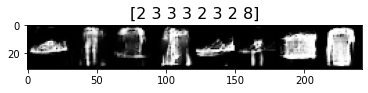

In [9]:
#plotting samples
test = torch.load('./gan_data_epoch_1')
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
for batch_idx, (temp, target) in enumerate(test):
    img_grid = make_grid(temp[0:8,], nrow=8)
    img_target_labels = target[0:8,].numpy()
    break
    
plt.imshow(img_grid.detach().cpu().numpy().transpose((1,2,0)))
plt.rcParams['figure.figsize'] = (10, 2)
plt.title(img_target_labels, size=16)
plt.show()